# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
!pwd

/p/Users/andy/Dropbox/_UDACITY/Reinforcement Learning/TennisCoop4


In [3]:
env = UnityEnvironment(file_name="Tennis_Windows_x86_64/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [5]:
print(brain)

Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [6]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]
# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [7]:
runSample=False  #set to true to run sample/take random actions in environment

In [8]:

if (runSample): 
    for i in range(1, 6):                                      # play game for 5 episodes
        env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)
        while True:
            actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
            actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            scores += env_info.rewards                         # update the score (for each agent)
            states = next_states                               # roll over states to next time step
            if np.any(dones):                                  # exit loop if episode finished
                break
        print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

When finished, you can close the environment.

In [9]:
if (runSample): 
    env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

## Implement MADDPG policy

### Setup Parameters

This uses a basic structure 'Parameters' to encapsalate all common parameters

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from Parameters import Parameters

p=Parameters()
p.set_defaults()
p.BATCH_SIZE=256
p.STEPS_BEFORE_LEARN=5
p.NUM_LEARN_STEPS=25
p.STATE_SIZE=state_size
p.ACTION_SIZE=action_size
p.NUM_AGENTS=num_agents
p.BUFFER_SIZE=int(5.0e4)
p.LR_ACTOR=.0001
p.LR_CRITIC=.001
p.TAU = 0.07
p.WEIGHT_DECAY=0
p.EPSILON=.99
p.EPSILON_DECAY=.9994
p.GAMMA = 0.97
p.GAMMA_DECAY = 1.0001
p.NOISE_SIGMA=.3
p.DEVICE= torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = p.DEVICE

print(p)

Parameters:
STATE_SIZE(0):24
ACTION_SIZE(0):2
NUM_AGENTS(0):2
RANDOM_SEED(1):1
BUFFER_SIZE(ie5):50000
BATCH_SIZE(512):256
STEPS_BEFORE_LEARN(15) :5
NUM_LEARN_STEPS(10):25
GAMMA(.99):0.97
GAMMA_MAX(.99):0.99
GAMMA_DECAY(1.001):1.0001
TAU Size(1e-3):0.07
LR_ACTOR(ie-4):0.0001
LR_CRITIC(1e-5):0.001
WEIGHT_DECAY(0):0
DEVICE(cpu):cuda:0
EPSILON(1.0):0.99
EPSILON_MIN(.1) :0.1
EPSILON_DECAY(.995) :0.9994
NOISE_SIGMA(0.2):0.3



In [13]:
from maddpg_agent import DDPGAgent,MADDPGAgent
agent = MADDPGAgent(p)

In [14]:
print(agent.agents[0].actor_local)
print(agent.agents[1].actor_local)

Actor(
  (fc1): Linear(in_features=48, out_features=96, bias=True)
  (do1): Dropout(p=0.2)
  (bn1): LayerNorm(torch.Size([96]), eps=1e-05, elementwise_affine=True)
  (fc2): Linear(in_features=96, out_features=96, bias=True)
  (bn2): LayerNorm(torch.Size([96]), eps=1e-05, elementwise_affine=True)
  (fc3): Linear(in_features=96, out_features=96, bias=True)
  (bn3): LayerNorm(torch.Size([96]), eps=1e-05, elementwise_affine=True)
  (fc4): Linear(in_features=96, out_features=2, bias=True)
)
Actor(
  (fc1): Linear(in_features=48, out_features=96, bias=True)
  (do1): Dropout(p=0.2)
  (bn1): LayerNorm(torch.Size([96]), eps=1e-05, elementwise_affine=True)
  (fc2): Linear(in_features=96, out_features=96, bias=True)
  (bn2): LayerNorm(torch.Size([96]), eps=1e-05, elementwise_affine=True)
  (fc3): Linear(in_features=96, out_features=96, bias=True)
  (bn3): LayerNorm(torch.Size([96]), eps=1e-05, elementwise_affine=True)
  (fc4): Linear(in_features=96, out_features=2, bias=True)
)


### savePrintScores()

prints progresss and saves network

- in parameters:
    - i_episode     :   current episode
    - save_interval :   how often to save network
    - score_average :   current average of scores
    - scores        :   current scores
    - p             :   parameter object
    

In [15]:
solved=False

def save_print_scores(i_episode,save_interval,score_average,scores,max_score, p):
    score_string=""
    save_string="          "
    solved_string="       "
    global solved
    score_string=str('\r         Episode {}, Average Score: {:.4f}, Std Dev: {:.2f}, Eps: {:.2f}, gam: {:.2f}'\
          .format(i_episode, score_average, np.std(scores), p.EPSILON, p.GAMMA))

    if i_episode % save_interval==0 and not solved:
        for i in range(p.NUM_AGENTS):
            torch.save(agent.agents[i].actor_local.state_dict(), 'checkpoints\checkpoint_actor'+str(i)+'_opt.pth')
        save_string=str("\r saved ")

    if score_average > 0.5:
        solved=True
        solved_string="\r*solved* "
        if score_average == max_score:
            for i in range(p.NUM_AGENTS):
                torch.save(agent.agents[i].actor_local.state_dict(), 'checkpoints\optimum_checkpoint_actor'+str(i)+'_opt.pth')
            save_string=str("\r opt saved")
    print(solved_string+score_string+save_string)


### updateLrSteps()

updates Learning Rate and number of steps

- in parameters:
    - i_episode     :   current episode
    - p             :   parameter object
    

In [16]:
def updateLrSteps(i_episode,score_average):
    if i_episode == 1000:
        p.STEPS_BEFORE_LEARN=40
        p.NUM_LEARN_STEPS=30
        agent.lr_step()
    if i_episode  == 3000:
        p.STEPS_BEFORE_LEARN=50
        p.NUM_LEARN_STEPS=20
    if score_average > 0.5:
        p.STEPS_BEFORE_LEARN=10
        p.NUM_LEARN_STEPS=10

## Train Agents

##### (Note:You can safely Interupt Kernel to stop early)

In [ ]:
from collections import deque
import math

average_period=100
scores_deque = deque(maxlen=average_period)
scores_global = []
average_global = []

p.STEPS_BEFORE_LEARN=5
p.NUM_LEARN_STEPS=50


def ddpg(n_episodes=10000,save_interval=100):
    try:
        max_score=0
        for i_episode in range(1, n_episodes+1):
            env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
            states = env_info.vector_observations                  # get the current state (for each agent)
            prev_states=states
            agent.reset()
            scores = np.zeros(num_agents)                          # initialize the score (for each agent)
            score_average = 0
            while(True):
                actions = agent.act(prev_states,states, add_noise=True)
                env_info = env.step(actions)[brain_name]           # send all actions to the environment
                next_states = env_info.vector_observations         # get next state (for each agent)
                rewards = env_info.rewards                         # get reward (for each agent)
                dones = env_info.local_done                        # see if any episode finished
                agent.step(prev_states, states, actions, rewards, next_states, dones) # take a step using agent
                prev_states = states
                states = next_states                               # roll over states to next time step
                scores += rewards                                  # update the score (for each agent)
                if np.any(dones):                                  # exit loop if episode finished
                    break

            score = np.mean(scores)
            scores_deque.append(score)
            score_average = np.mean(scores_deque)
            scores_global.append(score)
            average_global.append(score_average)
            if score_average>max_score:
                max_score=score_average
            #np.save("scores",scores)
            #np.save("scores_global",scores_global)
            #np.save("average_global",average_global)
            #updateLrSteps(i_episode,score_average)
            
            #if score_average>0.01:
            p.EPSILON = max(p.EPSILON * p.EPSILON_DECAY,p.EPSILON_MIN)
            p.GAMMA = min(p.GAMMA_MAX,p.GAMMA*p.GAMMA_DECAY)

            save_print_scores(i_episode,save_interval,score_average,scores,max_score,p)
 
    except (KeyboardInterrupt,SystemExit):
        print("exiting")
        save_print_scores(i_episode,save_interval,score_average,scores,max_score,p)
    return scores_global, average_global

scores, averages = ddpg()


         Episode 1, Average Score: -0.0050, Std Dev: 0.00, Eps: 0.99, gam: 0.97          
         Episode 2, Average Score: -0.0050, Std Dev: 0.00, Eps: 0.99, gam: 0.97          
         Episode 3, Average Score: -0.0050, Std Dev: 0.00, Eps: 0.99, gam: 0.97          
         Episode 4, Average Score: -0.0050, Std Dev: 0.00, Eps: 0.99, gam: 0.97          
         Episode 5, Average Score: -0.0050, Std Dev: 0.00, Eps: 0.99, gam: 0.97          
         Episode 6, Average Score: -0.0050, Std Dev: 0.00, Eps: 0.99, gam: 0.97          
         Episode 7, Average Score: -0.0050, Std Dev: 0.00, Eps: 0.99, gam: 0.97          
         Episode 8, Average Score: -0.0050, Std Dev: 0.00, Eps: 0.99, gam: 0.97          
         Episode 9, Average Score: -0.0050, Std Dev: 0.00, Eps: 0.98, gam: 0.97          
         Episode 10, Average Score: -0.0050, Std Dev: 0.00, Eps: 0.98, gam: 0.97          
         Episode 11, Average Score: -0.0050, Std Dev: 0.00, Eps: 0.98, gam: 0.97          
        

         Episode 92, Average Score: 0.0167, Std Dev: 0.06, Eps: 0.94, gam: 0.98          
         Episode 93, Average Score: 0.0170, Std Dev: 0.06, Eps: 0.94, gam: 0.98          
         Episode 94, Average Score: 0.0173, Std Dev: 0.05, Eps: 0.94, gam: 0.98          
         Episode 95, Average Score: 0.0176, Std Dev: 0.06, Eps: 0.94, gam: 0.98          
         Episode 96, Average Score: 0.0179, Std Dev: 0.05, Eps: 0.93, gam: 0.98          
         Episode 97, Average Score: 0.0182, Std Dev: 0.06, Eps: 0.93, gam: 0.98          
         Episode 98, Average Score: 0.0185, Std Dev: 0.05, Eps: 0.93, gam: 0.98          
         Episode 99, Average Score: 0.0187, Std Dev: 0.05, Eps: 0.93, gam: 0.98          
 saved   Episode 100, Average Score: 0.0190, Std Dev: 0.06, Eps: 0.93, gam: 0.98
         Episode 101, Average Score: 0.0190, Std Dev: 0.00, Eps: 0.93, gam: 0.98          
         Episode 102, Average Score: 0.0195, Std Dev: 0.05, Eps: 0.93, gam: 0.98          
         Episode 

         Episode 183, Average Score: 0.0435, Std Dev: 0.06, Eps: 0.89, gam: 0.99          
         Episode 184, Average Score: 0.0430, Std Dev: 0.05, Eps: 0.89, gam: 0.99          
         Episode 185, Average Score: 0.0435, Std Dev: 0.06, Eps: 0.89, gam: 0.99          
         Episode 186, Average Score: 0.0435, Std Dev: 0.00, Eps: 0.89, gam: 0.99          
         Episode 187, Average Score: 0.0435, Std Dev: 0.06, Eps: 0.88, gam: 0.99          
         Episode 188, Average Score: 0.0435, Std Dev: 0.06, Eps: 0.88, gam: 0.99          
         Episode 189, Average Score: 0.0430, Std Dev: 0.00, Eps: 0.88, gam: 0.99          
         Episode 190, Average Score: 0.0440, Std Dev: 0.05, Eps: 0.88, gam: 0.99          
         Episode 191, Average Score: 0.0440, Std Dev: 0.00, Eps: 0.88, gam: 0.99          
         Episode 192, Average Score: 0.0440, Std Dev: 0.06, Eps: 0.88, gam: 0.99          
         Episode 193, Average Score: 0.0440, Std Dev: 0.06, Eps: 0.88, gam: 0.99          

         Episode 274, Average Score: 0.0600, Std Dev: 0.06, Eps: 0.84, gam: 0.99          
         Episode 275, Average Score: 0.0600, Std Dev: 0.06, Eps: 0.84, gam: 0.99          
         Episode 276, Average Score: 0.0600, Std Dev: 0.06, Eps: 0.84, gam: 0.99          
         Episode 277, Average Score: 0.0600, Std Dev: 0.00, Eps: 0.84, gam: 0.99          
         Episode 278, Average Score: 0.0605, Std Dev: 0.00, Eps: 0.84, gam: 0.99          
         Episode 279, Average Score: 0.0600, Std Dev: 0.00, Eps: 0.84, gam: 0.99          
         Episode 280, Average Score: 0.0600, Std Dev: 0.06, Eps: 0.84, gam: 0.99          
         Episode 281, Average Score: 0.0600, Std Dev: 0.05, Eps: 0.84, gam: 0.99          
         Episode 282, Average Score: 0.0600, Std Dev: 0.05, Eps: 0.84, gam: 0.99          
         Episode 283, Average Score: 0.0600, Std Dev: 0.06, Eps: 0.84, gam: 0.99          
         Episode 284, Average Score: 0.0600, Std Dev: 0.06, Eps: 0.83, gam: 0.99          

## Save last Trained Agents (optional)

In [16]:
torch.save(agent.agents[0].actor_local.state_dict(), 'checkpoints\manual_checkpoint_actor1_opt.pth')
torch.save(agent.agents[1].actor_local.state_dict(), 'checkpoints\manual_checkpoint_actor2_opt.pth')

## Plot Results of Training Run

C:\Users\andy\AppData\Local\conda\conda\envs\deeprl\lib\site-packages\numpy\core\_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\andy\AppData\Local\conda\conda\envs\deeprl\lib\site-packages\numpy\core\_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\andy\AppData\Local\conda\conda\envs\deeprl\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


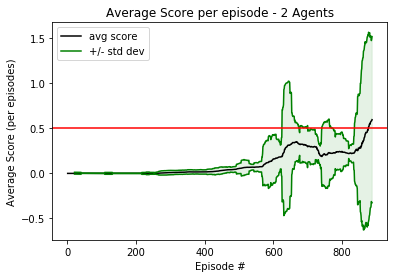

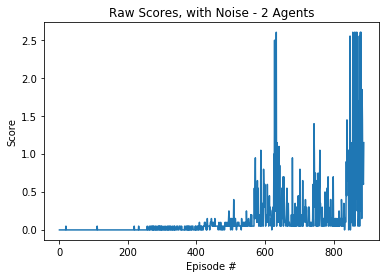

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


stdm=[average_global[i]-np.std(scores_global[i-20:i+3]) for i in range(len(scores_global))]
stdp=[average_global[i]+np.std(scores_global[i-20:i+3]) for i in range(len(scores_global))]

plt.plot(np.arange(1, len(scores_global)+1), average_global,color='black',label='avg score')
plt.plot(np.arange(1, len(scores_global)+1), stdm,color='green',label='+/- std dev')
plt.plot(np.arange(1, len(scores_global)+1), stdp,color='green')
plt.fill_between(range(len(scores_global)),
                 stdm,
                 stdp,
                 color='green',alpha=0.1,interpolate=True)
plt.title("Average Score per episode - 2 Agents")
plt.axhline(y=0.5, color='r', linestyle='-')
plt.ylabel('Average Score (per episodes)')
plt.xlabel('Episode #')
plt.legend(loc='upper left')
plt.show()

fig = plt.figure()
plt.title("Raw Scores, with Noise - 2 Agents")
plt.plot(np.arange(1, len(scores_global)+1), scores_global)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## Load and Run Optimal trained agents
##### (Note:You can safely Interupt Kernel to stop early
##### and if your not training, run all cells up to, and not including TrainAgent above)

In [20]:

for i in range(p.NUM_AGENTS):
    agent.agents[i].actor_local.load_state_dict(torch.load('checkpoints\optimum_checkpoint_actor'+str(i)+'_opt.pth'))
print("loaded optimal network")
                


loaded optimal network


In [21]:
from collections import deque
import time

average_period=100
rscores_deque = deque(maxlen=average_period)
rscores_global = []
raverage_global = []

def run_agent(n_episodes=100):
    try:
        for i_episode in range(1, n_episodes+1):
            env_info = env.reset(train_mode=False)[brain_name]      # reset the environment    
            states = env_info.vector_observations                  # get the current state (for each agent)
            prev_states=states
            agent.reset()
            rscores = np.zeros(num_agents)                          # initialize the score (for each agent)
            time.sleep(3)

            while(True):
                actions = agent.act(prev_states,states, add_noise=False)
                env_info = env.step(actions)[brain_name]           # send all actions to the environment
                next_states = env_info.vector_observations         # get next state (for each agent)
                rewards = env_info.rewards                         # get reward (for each agent)
                dones = env_info.local_done                        # see if any episode finished
                prev_states = states
                states = next_states                               # roll over states to next time step
                rscores += rewards                                  # update the score (for each agent)            
                if np.any(dones):                                  # exit loop if episode finished
                    break

            rscore = np.mean(rscores)
            rscores_deque.append(rscore)
            rscore_average = np.mean(rscores_deque)
            rscores_global.append(rscore)
            raverage_global.append(rscore_average)
            print("run score=",rscore," average=",rscore_average)
    except (KeyboardInterrupt,SystemExit):
         print("exiting...")
        
        
    return rscores_global,raverage_global

rscores,raverage=run_agent()
print("rscore=",rscores,raverage)


run score= 0.09500000160187483  average= 0.09500000160187483
run score= 2.650000039488077  average= 1.372500020544976
run score= -0.004999999888241291  average= 0.9133333470672369
run score= 2.650000039488077  average= 1.347500020172447
exiting...
rscore= [0.09500000160187483, 2.650000039488077, -0.004999999888241291, 2.650000039488077] [0.09500000160187483, 1.372500020544976, 0.9133333470672369, 1.347500020172447]


## Plot Results of Trained Run

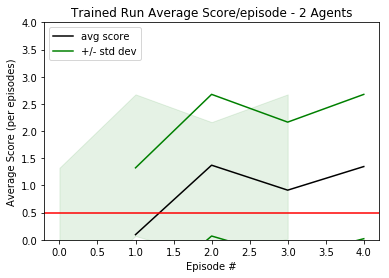

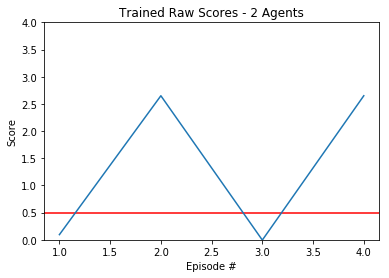

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


stdm=[raverage_global[i]-np.std(rscores_global[i-5:i+3]) for i in range(len(rscores_global))]
stdp=[raverage_global[i]+np.std(rscores_global[i-5:i+3]) for i in range(len(rscores_global))]

plt.plot(np.arange(1, len(rscores_global)+1), raverage_global,color='black',label='avg score')
plt.plot(np.arange(1, len(rscores_global)+1), stdm,color='green',label='+/- std dev')
plt.plot(np.arange(1, len(rscores_global)+1), stdp,color='green')
plt.ylim(0, 4)
plt.fill_between(range(len(rscores_global)),
                 stdm,
                 stdp,
                 color='green',alpha=0.1,interpolate=True)
plt.title("Trained Run Average Score/episode - 2 Agents")
plt.axhline(y=0.5, color='r', linestyle='-')
plt.ylabel('Average Score (per episodes)')
plt.xlabel('Episode #')
plt.legend(loc='upper left')
plt.show()

fig = plt.figure()
plt.ylim(0, 4)
plt.axhline(y=0.5, color='r', linestyle='-')
plt.title("Trained Raw Scores - 2 Agents")
plt.plot(np.arange(1, len(rscores_global)+1), rscores_global)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()